In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Defining the model (DeepLabV3+)

In [3]:
from tensorflow.keras.layers import Input, RepeatVector
import tensorflow as tf

def repeat_channels(input):
    return tf.concat([input] * 3, axis=-1)

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[1] // x.shape[1], dims[2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(num_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    model_input = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Repeat the single channel data to three channels
    repeated_input = Lambda(repeat_channels)(model_input)

    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=repeated_input
    )
    x = resnet50.get_layer("conv4_block6_out").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(IMG_HEIGHT // 4 // x.shape[1], IMG_WIDTH // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_out").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(IMG_HEIGHT // x.shape[1], IMG_WIDTH // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

In [4]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Resizing images
SIZE_X = 128
SIZE_Y = 128
# Number of classes for segmentation
n_classes=4

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'
train_images = io.imread(stack_path)

target_size = (256, 256)
resized_train_images = []
for image in train_images[:100]:
    resized_image = transform.resize(image, target_size, mode='reflect', anti_aliasing=True)
    resized_train_images.append(resized_image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)

Shape of the TIFF stack: (100, 256, 256)


In [8]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

target_size = (256, 256)
resized_train_masks = []
for image in train_masks[:100]:
    resized_image = cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_NEAREST)
    resized_train_masks.append(resized_image)
train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

Shape of the TIFF stack: (100, 256, 256)


(256, 256)


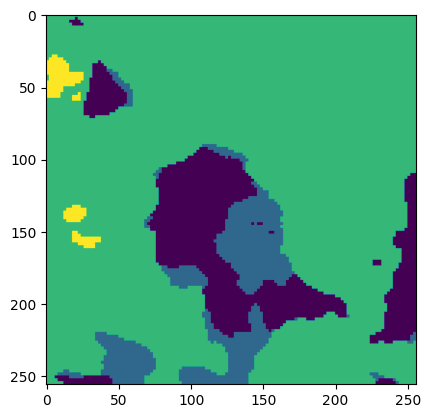

In [9]:
plt.imshow(train_masks[0])
print(train_masks[0].shape)

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

100 256 256


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [11]:
train_images = np.expand_dims(train_images, axis=3)
train_images.shape

(100, 256, 256, 1)

In [12]:
print("Before: ", train_images)
train_images = normalize(train_images, axis=1)
print("After: ", train_images)

Before:  [[[[0.46911765]
   [0.46911765]
   [0.47990196]
   ...
   [0.53063725]
   [0.53504902]
   [0.53504902]]

  [[0.46911765]
   [0.46911765]
   [0.47990196]
   ...
   [0.53063725]
   [0.53504902]
   [0.53504902]]

  [[0.47598039]
   [0.47598039]
   [0.48088235]
   ...
   [0.50563725]
   [0.51102941]
   [0.51102941]]

  ...

  [[0.50710784]
   [0.50710784]
   [0.48602941]
   ...
   [0.48602941]
   [0.46789216]
   [0.46789216]]

  [[0.5252451 ]
   [0.5252451 ]
   [0.5247549 ]
   ...
   [0.48357843]
   [0.47230392]
   [0.47230392]]

  [[0.5252451 ]
   [0.5252451 ]
   [0.5247549 ]
   ...
   [0.48357843]
   [0.47230392]
   [0.47230392]]]


 [[[0.1129902 ]
   [0.1129902 ]
   [0.11936275]
   ...
   [0.2379902 ]
   [0.27279412]
   [0.27279412]]

  [[0.1129902 ]
   [0.1129902 ]
   [0.11936275]
   ...
   [0.2379902 ]
   [0.27279412]
   [0.27279412]]

  [[0.12132353]
   [0.12132353]
   [0.12867647]
   ...
   [0.21397059]
   [0.24387255]
   [0.24387255]]

  ...

  [[0.4747549 ]
   [0.4747549 

In [13]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(100, 256, 256, 1)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90, 256, 256, 1)
(10, 256, 256, 1)
(90, 256, 256, 1)
(10, 256, 256, 1)


In [15]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [16]:
# Categorical encoding
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [17]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [1.91622145 2.87511231 0.33283441 7.94722546]


In [18]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(IMG_CHANNELS)

print(y_test_cat.shape)

1
(10, 256, 256, 4)


In [19]:
print(X_train[0].shape)
model = DeeplabV3Plus(n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['lambda[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                

In [20]:
history = model.fit(X_train, y_train_cat,
                    epochs=6,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/6
3/3 [==============================] - 109s 17s/step - loss: 4.2193 - accuracy: 0.4467 - val_loss: 2.8176 - val_accuracy: 0.0317
Epoch 2/6
3/3 [==============================] - 3s 888ms/step - loss: 1.9053 - accuracy: 0.7362 - val_loss: 1.0965 - val_accuracy: 0.0308
Epoch 3/6
3/3 [==============================] - 3s 838ms/step - loss: nan - accuracy: 0.3253 - val_loss: nan - val_accuracy: 0.1278
Epoch 4/6
3/3 [==============================] - 2s 825ms/step - loss: nan - accuracy: 0.1308 - val_loss: nan - val_accuracy: 0.1278
Epoch 5/6
3/3 [==============================] - 3s 843ms/step - loss: nan - accuracy: 0.1308 - val_loss: nan - val_accuracy: 0.1278
Epoch 6/6
3/3 [==============================] - 2s 830ms/step - loss: nan - accuracy: 0.1308 - val_loss: nan - val_accuracy: 0.1278


In [21]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 166ms/step - loss: nan - accuracy: 0.1278
Accuracy is =  12.780150771141052 %


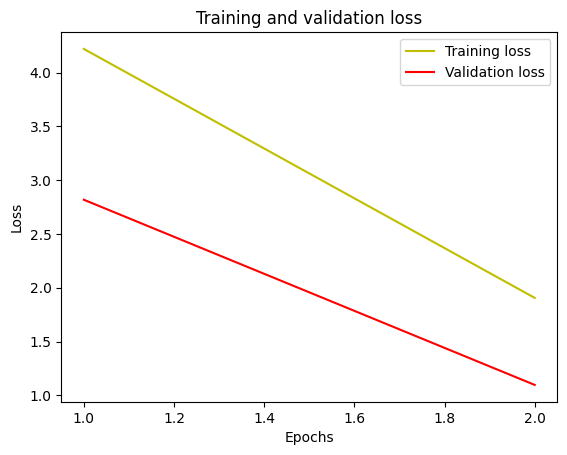

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

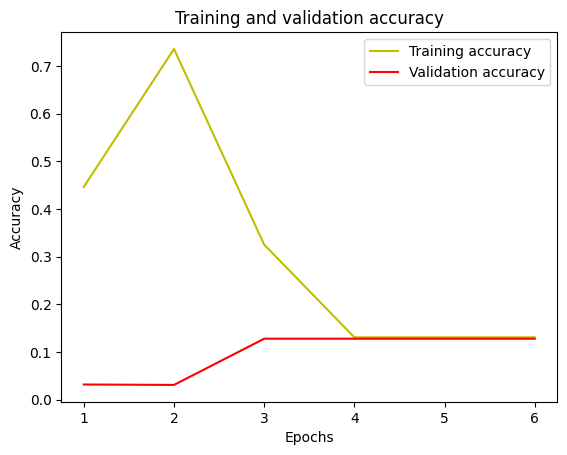

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [25]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [26]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [27]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (256, 256, 1)
Mask Shape:  (256, 256, 4)


In [28]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (270, 256, 256, 1)
Aug Mask Shape:  (270, 256, 256, 4)


In [29]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)
print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

Full Aug Image Shape:  (360, 256, 256, 1)
Full Aug Mask Shape:  (360, 256, 256, 4)


In [32]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
# Augmented version causes loss= nan, so not using it.
history_aug = history

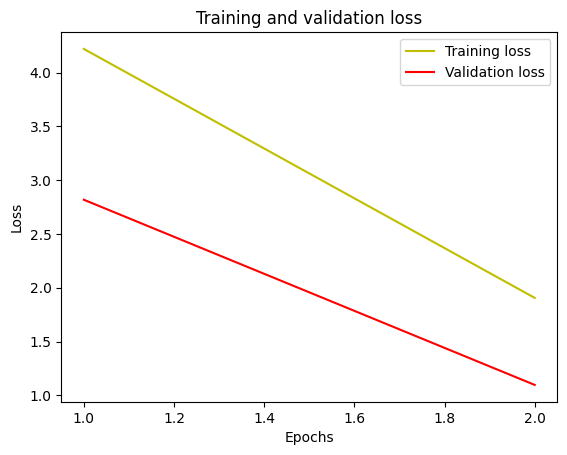

In [33]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

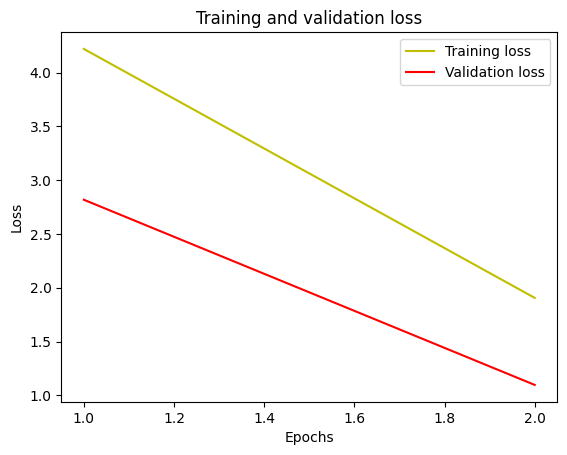

In [34]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

In [35]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 1s 948ms/step


1/1 [==============================] - 1s 937ms/step


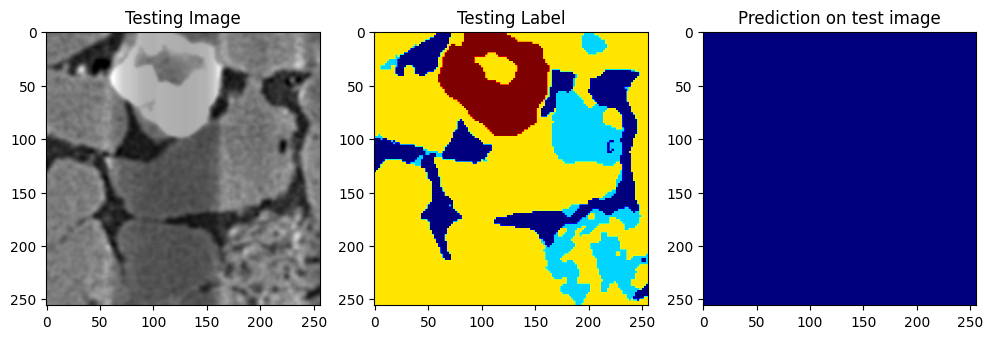

In [36]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [37]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (10, 256, 256, 4)
pred:  (10, 256, 256, 4)


In [38]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

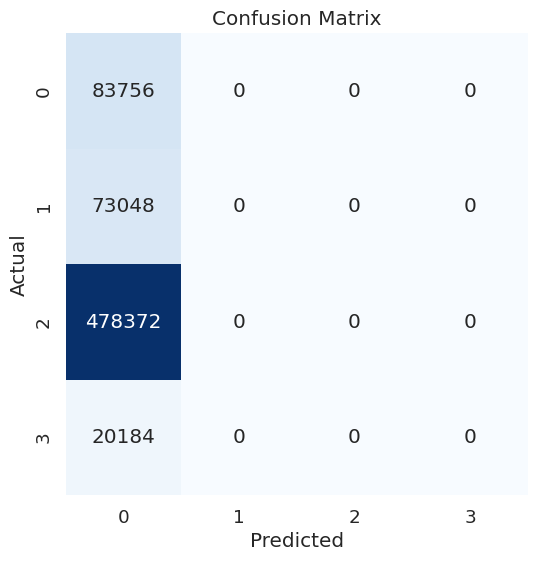

In [39]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 12.78%


In [41]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 13%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


In [43]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


In [44]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.031950377


In [45]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[ 83756.      0.      0.      0.]
 [ 73048.      0.      0.      0.]
 [478372.      0.      0.      0.]
 [ 20184.      0.      0.      0.]]
IoU for class1 is:  0.12780151
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.0


Training Set

In [46]:
# prediction on training set
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

3/3 [==============================] - 1s 259ms/step


1/1 [==============================] - 0s 30ms/step


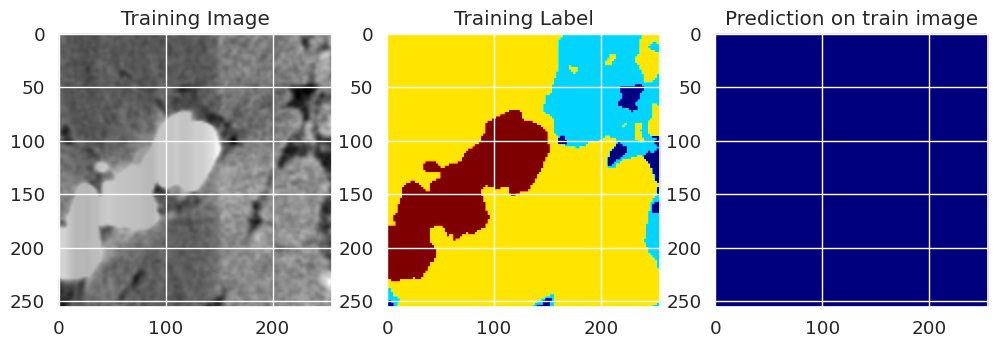

In [47]:
import random
train_img_number = random.randint(0, len(X_train))
train_img = X_train[train_img_number]
ground_truth=y_train[train_img_number]
train_img_norm=train_img[:,:,0][:,:,None]
train_img_input=np.expand_dims(train_img_norm, 0)
prediction = (model.predict(train_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(train_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [48]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (90, 256, 256, 4)
pred:  (90, 256, 256, 4)


In [49]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

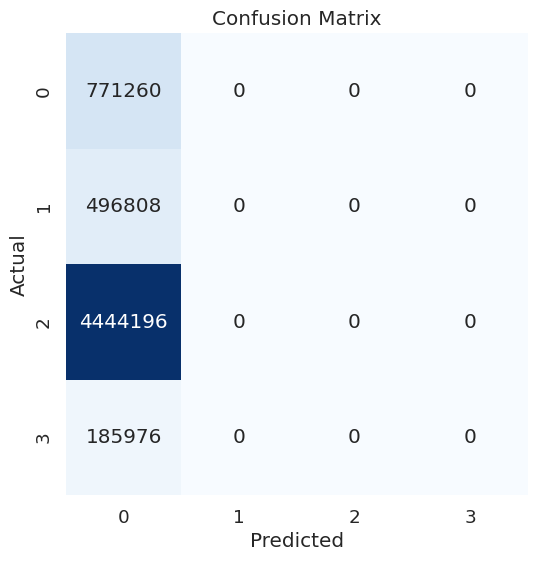

In [50]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 13.08%


In [52]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 13%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


In [54]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


In [55]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.03269026


In [56]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[ 771260.       0.       0.       0.]
 [ 496808.       0.       0.       0.]
 [4444196.       0.       0.       0.]
 [ 185976.       0.       0.       0.]]
IoU for class1 is:  0.13076104
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.0
